# HPDM097: Introduction to combinatorial optimisation for geospatial problems

## **Case study**: An applied facility location problem: sexual clinics in Hampshire, UK

The data you will use in the exercises in this computer lab is taken from a real facility location study conducted in Hampshire.  The data science team worked with commissioners, a public health team, and a community NHS trust in Hampshire that were reviewing the provision of sexual health clinics across the region.  The data science 'customers' had a number of concerns about the current provision of sexual health care.  One of these was the sustainability of the adult service across 28 locations.  There was a growing concern that care varied and the data scientists were asked to identify promising configurations that preserved fair access for patients.

**By the end of this lab you will have learnt how to:**

* represent a facility location problem in a general format suitable for algorithmic solution
* solve the p-median facility location problem using a brute force approach
* solve a larger p-median problem by applying an evolutionary optimisation approach
* obtain a good solution to large instances of the p-median problem by applying a Genetic Algorithm.

> Please use the conda environment `hds_logistics` when running this workbook.  You will also need to run this workbook in the same directory as `metapy`.  This is a small python package that contains the evolutionary and genetic algorithm code.

# Imports 

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#you will use itertools for enumerating all solutions in small instances.
from itertools import combinations

# Case study data

The car travel times in minutes from annoymised postcode sectors to annoymised clinic locations.

In [104]:
travel_matrix = pd.read_csv('data/clinic_car_travel_time.csv', 
                            index_col='sector')
travel_matrix.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,...,clinic_19,clinic_20,clinic_21,clinic_22,clinic_23,clinic_24,clinic_25,clinic_26,clinic_27,clinic_28
sector,,,,,,,,,,,,,,,,,,,,,
PS158,33.17,40.15,38.17,37.93,29.35,51.48,53.28,48.00,53.82,44.65,...,12.10,12.27,15.83,53.27,53.98,29.75,34.22,32.68,19.62,39.25
PS159,31.42,36.55,36.42,34.53,27.60,47.88,49.68,44.40,50.22,41.05,...,11.75,11.92,10.62,49.68,50.38,26.15,30.62,32.35,19.28,35.65
PS160,31.82,38.80,36.82,36.58,28.00,50.13,51.95,46.65,52.47,43.30,...,10.75,10.92,14.35,51.93,52.65,28.40,32.87,31.35,18.27,37.90
PS161,31.68,38.65,36.67,36.43,27.87,49.98,51.80,46.50,52.32,43.17,...,10.32,10.77,16.38,51.78,52.50,28.27,32.73,31.20,17.82,37.75
PS162,29.55,36.53,34.55,34.32,25.73,47.87,49.67,44.38,50.20,41.03,...,6.77,7.28,17.18,49.65,50.37,26.13,30.60,29.07,14.27,35.63


In [213]:
#no of cases by postcode sector...

cases = pd.read_csv('data/sh_demand.csv', index_col='sector')
cases.head()

,n_patients
sector,
PS1,3375
PS2,3338
PS3,2922
PS4,3191
PS5,3134


# Representating a solution

To solve the facility location problem using an an algorithm we need to decide how to represent a solution.  

We will represent a solution using a vector of length $p$ where $p <= P$.  Each element represents the index of a clinic.  For example, if we have $P = 28$ candidate locations for clinics and wish to find the best solution where $p = 4$

```python
solution = np.array([10, 0, 6, 12])
```
means that clinics which indicies 10, 0, 6, and 12 are included in the solution.

To select a set of clinics from a `pandas.DataFrame` you can use the code below.  The indicies are used select the column headers and the column headers are then used to select the column data from the dataframe.

In [107]:
solution = np.array([10, 0, 6, 12])

mask = travel_matrix.columns[solution]
travel_matrix[mask]

,clinic_11,clinic_1,clinic_7,clinic_13
sector,,,,
PS158,49.40,33.17,53.28,52.78
PS159,45.80,31.42,49.68,49.18
PS160,48.05,31.82,51.95,51.43
PS161,47.92,31.68,51.80,51.30
PS162,45.78,29.55,49.67,49.17
...,...,...,...,...
PS273,47.18,34.13,49.08,50.57
PS157,42.65,29.60,44.55,46.03
PS274,44.23,31.17,46.13,47.62


# Constructing a random solution

Rather than specifying a solution yourself you could

In [113]:
def random_solution(n_facilities, p, random_seed=None):
    '''
    construct a random solution for the facility location
    problem.  Returns vector of length p
    '''
    if random_seed is not None:
        np.random.seed(random_seed)
    
    solution = []
    while len(solution) < p:
        candidate = np.random.randint(0, n_facilities)
        if candidate not in solution:
            solution.append(candidate)
            
    return np.array(solution)

In [116]:
init_solution = random_solution(28, 4, random_seed=42)
init_solution

array([ 6, 19, 14, 10])

In [117]:
class WeightedAverageObjective:
    '''
    Encapsulates logic for calculation of 
    weighted average in a simple facility location problem
    '''
    def __init__(self, demand, travel_matrix):
        '''store the demand and travel times'''
        self.demand = demand
        self.travel_matrix = travel_matrix
        
    def fitness(self, solution):
        '''calculate the weighted average travel time for solution'''

        #only select clinics encoded with 1 in the solution (cast to bool) 
        
        mask = self.travel_matrix.columns[solution]
        active_facilities = self.travel_matrix[mask]
        
        #merge demand and travel times into a single DataFrame
        problem = self.demand.merge(active_facilities, on='sector', how='inner')
        
        #assume travel to closest facility
        problem['min_cost'] = problem.min(axis=1)

        #return weighted average
        return np.average(problem['min_cost'], 
                          weights=problem['n_patients'])

In [122]:
class MCLPObjective:
    '''
    Encapsulates logic for calculation of 
    maximal covering location problem objective
    '''
    def __init__(self, demand, travel_matrix, service_distance):
        '''store the demand and travel times'''
        self.demand = demand
        self.travel_matrix = travel_matrix
        self.service_distance = distance
        
    def fitness(self, solution):
        '''calculate the proportion within distance'''

        #only select clinics encoded with 1 in the solution (cast to bool) 
        mask = self.travel_matrix.columns[solution.astype(bool)]
        active_facilities = self.travel_matrix[mask]
        
        #merge demand and travel times into a single DataFrame
        problem = self.demand.merge(active_facilities, on='sector', how='inner')
        
        #assume travel to closest facility
        problem['min_cost'] = problem.min(axis=1)

        #return weighted average
        return np.average(problem['min_cost'], 
                          weights=problem['n_patients'])

In [123]:
obj = WeightedAverageObjective(cases, travel_matrix)
obj.fitness(solution)

14.480792199139968

# Solution of a small facility location problem by enumerating all possible combinations

For small problems it is possible to enumerate all combinations to locate the "optimal" solution.  

The function `all_combinations` below will provide a list of solutions representing an exhaustive solution space for a given problem.  For example, if the problem consisted of 10 candidate locations and you wish to evaluate solutions of size 4 then the solution space is fully represented by 210 unique solutions.

This method is straightforward for health service customers to understand and for small problems it is unusual to use a complex optimisation procedure.  As the facility location problem is NP hard, this strategy is not recommended for large scale problems.  The evaluation of the fitness of the solutions will become prohibative as the size of the problem begins to exceed 10.

In [153]:
def all_combinations(n_facilities, p):
    '''
    Returns all p sized combinations of an array containing
    indicies 0 to n_facilties - 1 
    '''
    facility = np.arange(n_facilities, dtype=np.uint8)
    return [np.array(a) for a in combinations(facility, p)]

In [162]:
# size 4 combinations of 10 candidate locations = 210
comb = all_combinations(n_facilities=10, p=4)
len(comb)

210

In [165]:
#take a look at index 0
comb[0]

array([0, 1, 2, 3], dtype=uint8)

In [166]:
#index 209
comb[-1]

array([6, 7, 8, 9], dtype=uint8)

# Exercise 1: Bruteforce solution

As an example we will work with the **first six clinics** and look to find the optimal 4 sites according to the weighted average.

**Task:**
* Generate all combinations to place 4 facilities in a problem with 6 candidate locations.
* For each of the solutions calculate the weighted average travel time.
* Select the solution with the lowest weight mean car travel time.
* Illustrate all of the solutions on a bar chart.  

**Questions:**
* Does the problem have a unique "optimal" solution or are there other solutions that a health service customer might consider?
* Are there any limitations with the data that make it important to report more than a single solution?
* What happens to the travel times and solution if $p$ is reduced to 3?

In [ ]:
# your code goes here ...

In [233]:
#example solution

# size 4 combinations of 6 candidate locations = 15 combinations
comb = all_combinations(n_facilities=6, p=4)
len(comb)

15

In [172]:
comb

[array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 4], dtype=uint8),
 array([0, 1, 2, 5], dtype=uint8),
 array([0, 1, 3, 4], dtype=uint8),
 array([0, 1, 3, 5], dtype=uint8),
 array([0, 1, 4, 5], dtype=uint8),
 array([0, 2, 3, 4], dtype=uint8),
 array([0, 2, 3, 5], dtype=uint8),
 array([0, 2, 4, 5], dtype=uint8),
 array([0, 3, 4, 5], dtype=uint8),
 array([1, 2, 3, 4], dtype=uint8),
 array([1, 2, 3, 5], dtype=uint8),
 array([1, 2, 4, 5], dtype=uint8),
 array([1, 3, 4, 5], dtype=uint8),
 array([2, 3, 4, 5], dtype=uint8)]

optimal cost: 12.902173372021958
optimal solution: [1 3 4 5]


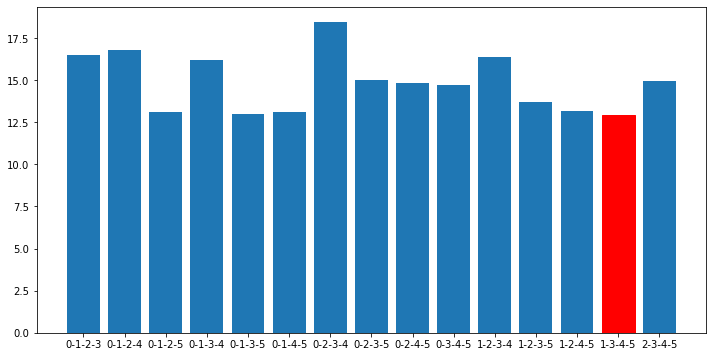

In [206]:
#example solution...

#create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

results = []
for solution in comb:
    results.append(obj.fitness(solution))
results = np.array(results)

#get the index of the minimum
optimal_index = np.argmin(results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

#convert solutions to strings

xlabels = []
for solution in comb:
    label = '-'.join(str(a) for a in solution)
    xlabels.append(label)

barlist = ax.bar(xlabels, results)
barlist[optimal_index].set_color('r')

print(f'optimal cost: {results[optimal_index]}')
print(f'optimal solution: {comb[optimal_index]}')

20 combinations
optimal cost: 13.493472285693834
optimal solution: [0 1 5]


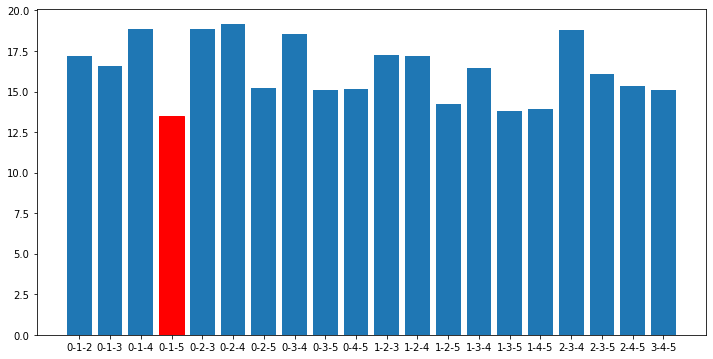

In [209]:
#reduce p to 3
comb = all_combinations(n_facilities=6, p=3)
print(f'{len(comb)} combinations')
#create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

results = []
for solution in comb:
    results.append(obj.fitness(solution))
results = np.array(results)

#get the index of the minimum
optimal_index = np.argmin(results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

#convert solutions to strings

xlabels = []
for solution in comb:
    label = '-'.join(str(a) for a in solution)
    xlabels.append(label)

barlist = ax.bar(xlabels, results)
barlist[optimal_index].set_color('r')

print(f'optimal cost: {results[optimal_index]}')
print(f'optimal solution: {comb[optimal_index]}')

# Exercise 2: Using random restarts with medium to large sized problems

When you encounter a medium to large instance of a facility location problem (or any optimisation problem) it is often tempting to move quickly onto a sophisticated solution method such as a evolutionary algorithm.  But how do you know that it is better than a simple heuristic?  

**Here you will use the random restarts algorithm (sometimes called random search) as a simple benchmark.**

Random restarts is simple heuristic.  You allocate a computational budget - either in terms of iterations or execution time - and randomly generate solutions and evaluate them. For example, you might specify an execution time limit of 10 seconds and in that time evaluate as many random solutions as possible.  

> A neat trick with this type of algorithm is to remember that it is 'Embarrassingly parallelisible'.  That is, if your machine has multiple virtual cores then you can run multiple random searches simultaneously and return the best solution.  

**Task:**
* Using the `random_solution` function defined earlier create another function `random_restarts` (or class `RandomRestarts` if you prefer) that runs for fixed number of iterations.  For example if you specify iterations as 10 then the algorithm generates 10 random solutions and evaluates them.  
* The function should return a tuple of the best cost and best solution found when minimising the weighted average car travel time.
* Problem: 20 candidate locations and a budget of 8 clinics to place.
* Try running the algorithm a few times or varying your budget. What do you notice?  What might you do to get a better understanding of the algorithms performance?

In [ ]:
#your code goes here ...

In [237]:
#example solution

def random_restarts(max_iter, obj, n_facilities=20, p=8, random_seed=None):
    
    np.random.seed(random_seed)
    
    # implementation of random restarts alg
    best_cost = np.Inf
    best_solution = None
    for i in range(max_iter):
        solution = random_solution(n_facilities, p)
        cost = obj.fitness(solution)
        
        if cost < best_cost:
            best_cost = cost
            best_solution = solution
            
    return best_cost, solution
        

In [252]:
max_iter = 1000

#create objective function...
obj = WeightedAverageObjective(cases, travel_matrix)

random_restarts(max_iter, obj)

(7.823814757104079, array([12,  8, 17, 18, 15, 11,  9,  7]))

# Exercise 3: Solution using a evolutionary algorithm

In [ ]:
def binary_all_combinations(n_facilities):
    binary = [0, 1]
    return [np.array(a) for a in itertools.product(binary, repeat=n_facilities)]